In [ ]:
%load_ext nb_black

In [1]:
# Import some python libraries
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import intake

In [2]:
# Setup a dask cluster
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=16, maximum=64, interval='2s', wait_count=3)

client = Client(cluster)
client

# `intake-esm`
intake-esm.readthedocs.io/

In [14]:
col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json")

In [29]:
cat = col.search(variable_id='ta',
                 experiment_id='historical',
                 table_id='Amon',
                 source_id='MPI-ESM1-2-LR',
                 member_id='r1i1p1f1')
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Amon,ta,gn,gs://cmip6/CMIP/MPI-M/MPI-ESM1-2-LR/historical...,NaN


In [33]:
# this gets xr.Datasets from netcdf files with `dask`
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 12*50}},
                                preprocess=None)
# show the list of available xr.Datasets
list(dset_dict)

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)


['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn']

In [34]:
# get first item
_,ds = dset_dict.popitem()
# extract xr.dataArray
da = ds['ta'].squeeze()

# lazy data
da.data

dask.array<getitem, shape=(1980, 19, 96, 192), dtype=float32, chunksize=(91, 19, 96, 192), chunktype=numpy.ndarray>

In [39]:
da = da.isel(plev=0)

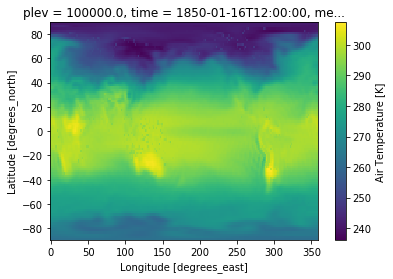

In [40]:
da.isel(time=0).plot()

In [44]:
da_gm = da.mean(['lon','lat']).load()

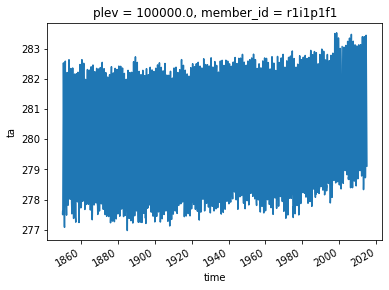

In [42]:
da_gm.plot()

In [41]:
def yearmean(ds,dim='time'):
    return ds.groupby(f'{dim}.year').mean().rename({'year':dim})

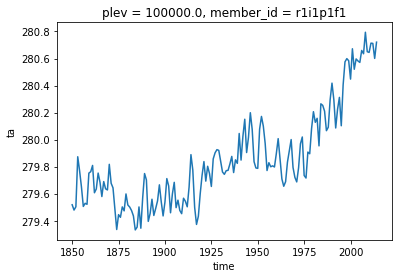

In [48]:
yearmean(da_gm).plot()

# regrid

In [ ]:
import xesmf as xe

def regrid(ds, deg=5):
    ds_out = xe.util.grid_global(deg,deg)
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    ds_out = regridder(ds)
    return ds_out

In [ ]:
# fails when lazy
hind_ym_regridded = regrid(hind_ym.load())

In [ ]:
# fails when lazy
hist_ym_regridded = regrid(hist_ym.load())

In [ ]:
obs_ym_regridded = regrid(obs_ym)

#### check the inputs 👀

#### Close down

In [ ]:
client.close()
cluster.close()